# Third Project - Automated Repair

## Overview

### The Task

For the first two submissions we asked you to implement a _Debugger_ as well as an _Input Reducer_. Both of these tools are used to help the developer to locate bugs and then manually fix them.

In this project, you will implement a technique of automatic code repair. To do so, you will extend the `Repairer` introduced in the [Repairing Code Automatically](https://www.debuggingbook.org/beta/html/Repairer.html) chapter of [The Debugging Book](https://www.debuggingbook.org/beta).

Your own `Repairer` should automatically generate _repair suggestions_ to the faulty functions we provide later in this notebook. This can be achieved, for instance, by changing various components of the mutator, changing the debugger, or the reduction algorithm. However, you are neither reguired to make all these changes nor required to limit yourself to the changes proposed here.

### The Submission

The time frame for this project is **3 weeks**, and the deadline is **Februrary 5th, 23:59**.  

The submission should be in form of a Jupyter notebook and you are expected to hand in the submission as a .zip-archive. The notebook should, apart from the code itself, also provide sufficient explanations and reasoning (in markdown cells) behind the decisions that lead to the solution provided. Projects that do not include explanations cannot get more than **15 points**.

In [1]:
import bookutils

## A Faulty Function and How to Repair It
Before discussing how to use and extend the Repairer, we first start by introducing a new (and highly complex) function that is supposed to return the larger of two values.

In [2]:
def larger(x, y):
    if x < y:
        return x
    return y

Unfortunately, we introduced a bug which makes the function behave the exact opposite way as it is supposed to:

In [3]:
larger(1, 3)

1

To fix this issue, we could try to debug it, using the tools we have already seen. However, given the complexity of the function under test (sorry for the irony), we might want to automatically repair the function, using the *Repairer* introduced in *The Debugging Book*.

To do so, we first need to define set of test cases, which help the *Repairer* in fixing the function.

In [4]:
def larger_testcase():
    x = random.randrange(100)
    y = random.randrange(100)
    return x, y

In [5]:
def larger_test(x, y):
    m = larger(x, y)
    assert m == max(x, y), f"expected {max(x, y)}, but got {m}"

In [6]:
import math
import random

In [7]:
random.seed(42)

Let us generate a random test case for our function:

In [8]:
larger_input = larger_testcase()
print(larger_input)

(81, 14)


and then feed it into our `larger_test()`:

In [9]:
from ExpectError import ExpectError

In [10]:
with ExpectError():
    larger_test(*larger_input)

Traceback (most recent call last):
  File "<ipython-input-10-796785c98bd7>", line 2, in <module>
    larger_test(*larger_input)
  File "<ipython-input-5-e4a4c6e7072d>", line 3, in larger_test
    assert m == max(x, y), f"expected {max(x, y)}, but got {m}"
AssertionError: expected 81, but got 14 (expected)


As expected, we got an error – the `larger()` function has adefect.

For a complete test suite, we need a set of passing and failing tests. To be sure we have both, we create functions which produce dedicated inputs:

In [11]:
def larger_passing_testcase():
    while True:
        try:
            x, y = larger_testcase()
            _ = larger_test(x, y)
            return x, y
        except AssertionError:
            pass

In [12]:
def larger_failing_testcase():
    while True:
        try:
            x, y = larger_testcase()
            _ = larger_test(x, y)
        except AssertionError:
            return x, y

In [13]:
passing_input = larger_passing_testcase()
print(passing_input)

(10, 10)


With `passing_input`, our `larger()` function produces a correct result, and its test function does not fail.

In [14]:
larger_test(*passing_input)

In [15]:
failing_input = larger_failing_testcase()
print(failing_input)

(93, 62)


While `failing_input` leads to an error:

In [16]:
with ExpectError():
    larger_test(*failing_input)

Traceback (most recent call last):
  File "<ipython-input-16-c99f0d4988e0>", line 2, in <module>
    larger_test(*failing_input)
  File "<ipython-input-5-e4a4c6e7072d>", line 3, in larger_test
    assert m == max(x, y), f"expected {max(x, y)}, but got {m}"
AssertionError: expected 93, but got 62 (expected)


With the above defined functions, we can now start to create a number of passing and failing tests:

In [17]:
TESTS = 100

In [18]:
LARGER_PASSING_TESTCASES = [larger_passing_testcase()
                            for i in range(TESTS)]

In [19]:
LARGER_FAILING_TESTCASES = [larger_failing_testcase()
                            for i in range(TESTS)]

In [20]:
from StatisticalDebugger import OchiaiDebugger

Next, let us use _statistical debugging_ to identify likely faulty locations. The `OchiaiDebugger` ranks individual code lines by how frequently they are executed in failing runs (and not in passing runs).

In [21]:
larger_debugger = OchiaiDebugger()

In [22]:
def larger_test(x, y):
    m = larger(x, y)
    assert m == max(x, y), f"expected {max(x, y)}, but got {m}"

In [23]:
for x, y in LARGER_PASSING_TESTCASES + LARGER_FAILING_TESTCASES:
    with larger_debugger:
        m = larger_test(x, y)

Given the results of statistical debugging, we can now use the *Repairer* introduced in the book to repair our function. Here we use the default implementation which is initialized with the simple _StatementMutator_ mutator.

In [24]:
from Repairer_Copy import Repairer
from Repairer import StatementMutator
from Repairer_Copy import ConditionMutator, CrossoverOperator
from Repairer_Copy import DeltaDebugger

In [25]:
repairer = Repairer(larger_debugger, log=True)

Target code to be repaired:
def larger(x, y):
    if x < y:
        return x
    return y



In [26]:
best_tree, fitness = repairer.repair()

Evolving population: iteration   0/100 fitness = 1.0   
Best code (fitness = 1.0):
def larger(x, y):
    if x < y:
        return y
    return x
    return y

Reduced code (fitness = 1.0):
def larger(x, y):
    if x < y:
        return y
    return x

It took the MetaRepairer 4.3359925746917725 seconds to repair the given code


The *Repairer* successfully produced a fix.

## Implementation

As stated above, the goal of this project is to implement a repairer capable of producing a fix to the functions defined in *the Evaluation section*, as well as secret functions.  
To do this, you need to work with the _Repairer_ class from the book.
The _Repairer_ class is very configurable, so that it is easy to update and plug in various components: the fault localization (pass a different debugger that is a subclass of DifferenceDebugger), the mutation operator (set mutator_class to a subclass of `StatementMutator`), the crossover operator (set crossover_class to a subclass of `CrossoverOperator`), and the reduction algorithm (set reducer_class to a subclass of `Reducer`). You may change any of these components or make other changes at will.

For us to be able to test your implementation, you will have to implement the `debug_and_repair()` function defined here.

In [27]:
import astor

In [28]:
import ast

In [29]:
import re

In [30]:
from ast import NodeVisitor

In [31]:
from multiprocessing import Queue,Process

In [32]:
import inspect

In [33]:
import time

In [34]:
import copy

In [35]:
import warnings

In [36]:
from ast import NodeTransformer

In [37]:
from bookutils import print_content, show_ast

### Elitism

[_Elitism_](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) (also known as _elitist selection_) is a variant of genetic selection in which a small fraction of the fittest candidates of the last population are included unchanged in the offspring. By subclassing the evolve method of the `Repairer`, we can adjust how big the part of the unchanged candidates is.

In [38]:
class Repairer(Repairer):
    def evolve(self, population):
        """Evolve the candidate population by mutating and crossover, in this case including an elitist selection."""
        n = len(population)
        possible_fractions = [0.05,0.10,0.20]
        elite = int(n * possible_fractions[0])   #Compute integral fraction of population that is supposed to remain unchanged
        
        # Create offspring as crossover of parents
        offspring = []
        while len(offspring) < n:
            if len(offspring) < elite:           #Since the population is sorted by fitness, we can just check the current index 
                offspring += [copy.deepcopy(population[len(offspring)])]
                continue
            parent_1 = copy.deepcopy(random.choice(population))
            parent_2 = copy.deepcopy(random.choice(population))
            try:
                self.crossover.crossover(parent_1, parent_2)
            except CrossoverError:
                pass  # Just keep parents
            offspring += [parent_1, parent_2]

        # Mutate offspring
        offspring = [self.mutator.mutate(tree) for tree in offspring]

        # Add it to population
        population += offspring

        population.sort(key=self.fitness_key, reverse=True)
        population = population[:n] 

        return population

### `ValueMutator`
The `ValueMutator` class replaces one constant value by another one found in the source (say, `0` by `1` or `True` by `False`).

In [39]:
class ConstValueVisitor(NodeVisitor):
    """
    The ConstValueVisitor traverses the tree to extract all constant values from the AST
    """
    def __init__(self):
        self.const_values = []
        self.const_values_seen = set()
        super().__init__()
    
    def add_const_value(self,node):
        self.const_values.append(node)
        self.const_values_seen.add(node.value)
        
    def visit_Constant(self,node):
        self.add_const_value(node)
        return super().generic_visit(node)
    
    def generic_visit(self, node):
        return super().generic_visit(node)

In [40]:
def all_const_values(trees, tp = None):
    """Return all constant values from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    visitor = ConstValueVisitor()
    
    for tree in trees:
        visitor.visit(tree)
    
    const_nodes = visitor.const_values
    seen_values = visitor.const_values_seen
    return const_nodes, seen_values

In [41]:
class ValueMutator(StatementMutator):
    """Mutate constant values in an AST"""

    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.const_nodes, self.seen_values = all_const_values(self.source)  #TODO: Find all statements containing constant values yo 
        if self.log > 3:
            print("Found constant values: ",
                  [node.value for node in self.const_nodes])
    
    def choose_const_node(self):
        """Return a random constant node from source."""
        return random.choice(self.const_nodes)
    
    def mutatable_subnode(self,tree):
        """
        Returns a mutatable subnode for a given tree, i.e a node containing a constant
        """
        visitor = ConstValueVisitor()
        visitor.visit(tree)
        if(len(visitor.const_values)>0):
            return random.choice(visitor.const_values)
        else:
            return None    #None is returned if the source contains no constants
    
    def node_to_be_mutated(self,tree):
        """
        Same as 'mutatable_subnode', but also working for a list of trees
        """
        const_values = all_const_values(tree)[0]
        return random.choice(const_values)
        
    def find_replacement_value(self,node):
        """Return a replacing constant value from source for a given node"""
        for const_node in self.const_nodes:
            if(const_node.value != node.value):
                return const_node.value
    
        return None   #None is returned if the sources contain no constants
    
    def swap_values(self, node): 
        mutated_subnode = self.mutatable_subnode(node)
        if mutated_subnode is None:
            return super().swap(node)
        else:
            old_value = mutated_subnode.value
            replacing_value = self.find_replacement_value(mutated_subnode)   #Compute replacing constant
            mutated_subnode.value = replacing_value
            return node

    def visit(self, node):
        super(NodeTransformer, self).visit(node)  # Visits (and transforms?) children
        if not node.mutate_me:
            return node
        else:
            new_node = self.swap_values(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are value mutations. Return mutated tree."""
        
        new_tree = copy.deepcopy(tree)   
        node_to_be_mutated = self.node_to_be_mutated(new_tree)
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        node_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        ast.fix_missing_locations(new_tree)
        
        return new_tree

### Evolving Variable Names

Following the steps of `ConditionMutator`, implement a `IdentifierMutator` class that replaces one identifier by another one found in the source (say, `y` by `x`). Does it help fixing the `middle()` error?

In [42]:
class IdentifierVisitor(NodeVisitor):
    """
    The IdentifierVisitor traverses the AST to extract identifiers
    """
    def __init__(self):
        self.identifiers = []
        self.identifiers_seen = set()
        super().__init__()
    
    def add_identifier(self,node):
        self.identifiers.append(node)
        self.identifiers_seen.add(node.id)

    def visit_Name(self,node):
        self.add_identifier(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node)

In [43]:
def all_identifiers(trees, tp = None):
    """Return all identifiers from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""

    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    id_visitor = IdentifierVisitor()
    for tree in trees:
        id_visitor.visit(tree)
        
    return id_visitor.identifiers

def seen_ids(tree):
    """
    Returns the set of present ids in the given tree
    """
    id_visitor = IdentifierVisitor()
    id_visitor.visit(tree)
    return id_visitor.identifiers_seen

In [44]:
class IdentifierMutator(StatementMutator):
    """Mutate identifiers in an AST"""
    
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.identifiers = all_identifiers(self.source)
        if self.log > 3:
            print("Found statements containing the following identifiers: ",
                  [astor.to_source(id).strip() 
                   for id in self.identifiers])
            
    def update_current_identifiers(self, tree):
        """
        This method can be used to update the identifiers as soon as new nodes are inserted
        """
        self.identifiers = all_identifiers(tree)
            
    def node_to_be_mutated(self,tree):
        """
        Returns node from the given tree containing an identifier 
        """
        id_visitor = IdentifierVisitor()
        id_visitor.visit(tree)
        if (len(id_visitor.identifiers) > 0):
            return random.choice(id_visitor.identifiers)
        else:
            return None
    
    def mutatable_subnode(self, tree):
        """
        Same as `node_to_be_mutated`, but also works for multiple trees
        """
        id_visitor = IdentifierVisitor()
        id_visitor.visit(tree)
        if (len(id_visitor.identifiers) > 0):
            return random.choice(id_visitor.identifiers)
        else:
            return None
    
    def get_replacing_id(self,node):
        """
        Returns an id from source which is supposed to replace the id of the given node
        """
        current_id = node.id
        random_id = random.choice(self.identifiers).id
        if(len(self.identifiers) == 1):
            return current_id
        else:
            while(str(current_id) == str(random_id)):
                random_id = random.choice(self.identifiers).id
            return random_id
        
    def swap_ids(self, node):
        """
        Sets the id of a given node to the id of another node from source
        """
        mutate_node = self.mutatable_subnode(node)
        if mutate_node is None:
            print("There is no mutatable subnode")
            return super().swap(node)
        else:
            old_id = mutate_node.id
            replacing_id = self.get_replacing_id(mutate_node)
            mutate_node.id = replacing_id
            return node

    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.swap_ids(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are id mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        node_to_be_mutated = self.node_to_be_mutated(new_tree)
        node_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree

### Loop Mutator
The following class mutates the ranges of loops, i.e. `range(1,n)` => `range(1,n+1)` or `range(1,n)` => `range(1,n-1)`

In [45]:
class LoopVisitor(NodeVisitor):
    """
    The loop visitor traverses an AST to extract nodes containing for loops
    """
    def __init__(self):
        self.loops = []
        super().__init__()
    
    def add_loop(self,node):
        self.loops.append(node)

    def visit_For(self,node):
        self.add_loop(node)
        return super().generic_visit(node)
    
    def visit_While(self,node):
        self.add_loop(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node)

In [46]:
def all_loops(trees, tp = None):
    """Return all loops from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    loop_visitor = LoopVisitor()
    for tree in trees:
        loop_visitor.visit(tree)
        
    return loop_visitor.loops

In [47]:
class LoopMutator(StatementMutator):
    """Mutate Loops in an AST"""
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.loops = all_loops(self.source)
        self.identifiers = all_identifiers(self.source)
        self.num_replaced_ids = 0
        if self.log > 3:
            print("Found the following Loops in Source: ",
                  [astor.to_source(loop).strip() 
                   for loop in self.loops])
            
    def loop_to_be_mutated(self,tree):
        """
        Returns a loop from tree
        """
        loop_visitor = LoopVisitor()
        loop_visitor.visit(tree)
        if(len(loop_visitor.loops)>0):
            return random.choice(loop_visitor.loops)
        else:
            return None
        
    def get_replacing_id(self,node):
        """
        Returns a id that is supposed to replace the id of a variable a for loop
        """
        current_id = node.id
        random_id = random.choice(self.identifiers).id
        if(len(self.identifiers) == 1):
            return current_id
        else:
            while(str(current_id) == str(random_id)):
                random_id = random.choice(self.identifiers).id
            return random_id
        
    def mutate_range(self, node):
        """
        This method either renames the target variable and all corresponding references in the loop
        or mutates the id of the variable, e.g. range(1,x) => range(1,y)
        """
        has_target = hasattr(node, 'target')
        has_iter = hasattr(node, 'iter')
        
        range_mutation = random.choice(["rename_target","swap_iter_id"])   #Determine the mutation to be performed
        if (has_target and has_iter):  #Assure we are mutating a for loop
            
            if(range_mutation == "rename_target"):
                target_var_id = node.target.id
                new_var_id = "replacement_id" + str(self.num_replaced_ids)
                self.num_replaced_ids += 1
                node.target.id = new_var_id
                for assignment in all_assignments(node)[0]:
                    for var in all_identifiers(assignment.value):
                         if var.id == target_var_id:
                            var.id = new_var_id
                            
            elif(range_mutation == "swap_iter_id"):
                name_visitor = IdentifierVisitor()
                name_visitor.visit(node.iter)
                
                name_to_swap = random.choice(all_identifiers(node.iter))
                
                id_to_swap = name_to_swap.id
                replacing_id = self.get_replacing_id(name_to_swap)
                name_to_swap.id = replacing_id
                body_names = all_identifiers(node.body)
                
                for name in body_names:
                    if(name.id == replacing_id):
                        name.id = id_to_swap    
        return node   
        
    def swap_range(self, node):
        if not hasattr(node, 'iter'):
            return super().swap(node)
        else:
            old_iter = node.iter
            node = self.mutate_range(node)
  #          node.iter = replacing_iter
            return node
    
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.swap_range(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are id mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        node_to_be_mutated = self.loop_to_be_mutated(new_tree)
        node_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree

### AssignmentMutator
The following class mutates Assignments by adding, subtracting or multiplying constants or variables from source

In [48]:
class AssignVisitor(NodeVisitor):
    """
    The AssignVisitor extracts all assignments from the AST
    """
    def __init__(self):
        self.assigns = []
        self.seen_assigns = set()
        super().__init__()
    
    def add_assignment(self,node):
        self.assigns.append(node)
        self.seen_assigns.add(node)        
    
    def visit_Assign(self,node):
        self.add_assignment(node)
        return super().generic_visit(node)
    
    def visit_AugAssign(self,node):
        self.add_assignment(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node)

In [49]:
def all_assignments(trees, tp = None):
    """Return all identifiers from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    assign_visitor = AssignVisitor()
    for tree in trees:
        assign_visitor.visit(tree)
        
    return (assign_visitor.assigns,assign_visitor.seen_assigns)

In [50]:
class AssignMutator(StatementMutator):
    """Mutate Loops in an AST"""
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.assignments, self.seen_assignments = all_assignments(self.source)
        self.const_values, self.seen_values = all_const_values(self.source)
        self.identifiers = all_identifiers(self.source)

        if self.log > 3:
            print("Found statements containing the following assignments: ",
                  [astor.to_source(assign).strip() 
                   for assign in self.assignments])
            
    def assignment_to_be_mutated(self,tree):
        """
        Returns an assignment from tree that is supposed to be mutated
        """
        assign_visitor = AssignVisitor()
        assign_visitor.visit(tree)
        return random.choice(assign_visitor.assigns)
    
    def choose_mutator_op(self):
        choice =  random.choice(["add","sub","mult","div"])  #Draw a mutation operator
        if choice == "add":
            return ast.Add
        elif choice == "sub":
            return ast.Sub
        elif choice == "mult":
            return ast.Mult
        else:
            return ast.Div
    
    def mutate_assignment(self, node):
        if(len(self.seen_values)>0):
            replacing_const = ast.Constant(random.choice(tuple(self.seen_values)))
        elif(len(self.identifiers)>0):
            replacing_const = random.choice(self.identifiers)
        else:
            replacing_const = ast.Constant(1)    #Add, subtract or multiply by zero if no constants or vars are in source
            
        if hasattr(node, 'op') or hasattr(node, 'value'):
            replacing_op = self.choose_mutator_op()
           
            current_assign_value = node.value
            replacing_assignment = ast.BinOp(left=current_assign_value, op = replacing_op(), right=replacing_const)
            node.value = replacing_assignment
            return node
        else:
            return super().insert(node)
                   
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.mutate_assignment(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are assignments mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        assignment_to_be_mutated = self.assignment_to_be_mutated(new_tree)
        assignment_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree

### OperatorMutator
The `OperatorMutator` class mutates the operators in assignments, e.g. `x = a + b` => `x = a * b` ; `x += b` => `x *= b`

In [51]:
class OperatorVisitor(NodeVisitor):
    """
    The Operator Vistor extracts all nodes containing operators from source
    """
    def __init__(self):
        self.operators = []
        self.seen_ops = set()
        super().__init__()
    
    def add_operator(self,node):
        self.operators.append(node)
        self.seen_ops.add(node.op)
        
    def visit_BinOp(self,node):
        self.add_operator(node)
        return super().generic_visit(node)
    
    def visit_UnaryOp(self, node):
        self.add_operator(node)
        return super().generic_visit(node)
    
    def visit_BoolOp(self, node):
        self.add_operator(node)
        return super().generic_visit(node)
    
    def visit_AugAssign(self,node):
        self.add_operator(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node) 

In [52]:
def all_operators(trees, tp = None):
    """Return all identifiers from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""

    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    op_visitor = OperatorVisitor()
    for tree in trees:
        op_visitor.visit(tree)
        
    return op_visitor.operators

In [53]:
class OperatorMutator(StatementMutator):
    """Mutate Operators in an AST"""
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.operators = all_operators(self.source)

        if self.log > 3:
            print("Found statements containing the following assignments: ",
                  [astor.to_source(op).strip() 
                   for op in self.operators])
            
    def operator_to_be_mutated(self,tree):
        """
        Returns an operator node which is supposed to be mutated
        """
        op_visitor = OperatorVisitor()
        op_visitor.visit(tree)
        if(len(op_visitor.operators)>0):
            return random.choice(op_visitor.operators)
        else:
            return None
    
    def choose_mutated_op(self, node):
        """
        Returns an operator replacing the current operator of the node
        """
        choices = list()
        
        #List of available Binary Operators
        bin_ops = [ast.Add,ast.Sub,ast.Mult,ast.Div,ast.FloorDiv,ast.Mod,ast.Pow,ast.LShift,ast.RShift,ast.BitOr,ast.BitXor,ast.BitAnd,ast.MatMult]
        if any(isinstance(node.op, operator) for operator in bin_ops):     #Check if current operator is binary operator 
            choices = [ast.Add,ast.Mult,ast.Div,ast.Sub]
        else:                                                              #Otherwise, it is a unary operator
            choices = [ast.UAdd,ast.Not,ast.Invert,ast.USub]
        
        choice = random.choice(choices)
        
        while(isinstance(node.op, choice)):
            choice = random.choice(choices)
            
        return choice()  
    
    def mutate_operator(self, node):
        if hasattr(node, 'op'):
            replacing_op = self.choose_mutated_op(node)
            node.op = replacing_op
        return node
                   
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.mutate_operator(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are id mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        assignment_to_be_mutated = self.assignment_to_be_mutated(new_tree)
        assignment_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree

### Test-Function Runner
The following class facilitates the detection of endless loops, and terminates the execution of functions that take a suspiciously long amount of time to execute

In [54]:
def run_function(args_list, function,feedback_queue):
    for args in args_list:
        try:
            function(**args)
            feedback_queue.put(1) #Representing passed
        except Exception as e:
            feedback_queue.put(0) #Representing failure
        
def function_runner_process(function, args_list):
    """
    This method creates a Process which runs the test function with given arguments. It is terminated, if
    the execution takes longer than a treshold defined below
    """
    
    feedback_communicator = Queue()
    procs = []
    
    fun_runner = Process(target=run_function, args = (args_list, function, feedback_communicator))
    procs.append(fun_runner)
    fun_runner.start()
    
    TIMEOUT = 0.5
    start = time.time()
    
    while time.time() - start <= TIMEOUT:        
        if not any(p.is_alive() for p in procs):
            break   #We can break this loop if all test executions are finished in time
        time.sleep(.05)  
    else:
        for p in procs:       #Kill all processes that did not finish in time
            p.terminate()
            p.join()
    
    num_passed = 0
    
    while(not feedback_communicator.empty()):
        feedback = feedback_communicator.get()
        num_passed += feedback     #Feedback is 0 for a failed, 1 for a passed test
        
    return num_passed

In [55]:
class Repairer(Repairer):
    def run_test_set(self, test_set, validate=False):
        """Run given `test_set`
        (`DifferenceDebugger.PASS` or `DifferenceDebugger.FAIL`).
        If `validate` is set, check expectations.
        Return number of passed tests."""
        
        collectors = self.debugger.collectors[test_set]     
        function = self.debugger.function()
        
        args_to_test = list()
        
        for c in collectors:
            if self.log >= 4:
                print(f"Testing {c.id()}...", end="")
            args_to_test.append(c.args())
            
        num_passed = function_runner_process(function, args_to_test)
        
        return num_passed

### Meta Mutator
The following class is a combination of the Mutator classes defined above, considering Mutations of each class (`ConditionMutator`, `IdentifierMutator`, `ValueMutator`, `RangeMutator`). This can then be used as the Mutator class of our `Repairer` to allow the fixing of multiple problems.

In [56]:
class MetaMutator(StatementMutator):
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.value_mutator = ValueMutator(source = self.source, log = True)
        self.condition_mutator = ConditionMutator(source = self.source, log = True)
        self.identifier_mutator = IdentifierMutator(source = self.source, log = True)
        self.assignment_mutator = AssignMutator(source = self.source, log = True)
        self.loop_mutator = LoopMutator(source = self.source, log = True)
        self.op_mutator = OperatorMutator(source = self.source, log = True)
    
    def check_applicability(self, choice, node):
        """
        Check if a given mutation is applicable on a node, e.g. to prevent the application of an operation
        mutator on a statement containing no operator
        """
        if choice == "identifier_mutator":
            return self.identifier_mutator.mutatable_subnode(node) is not None
        elif choice == "value_mutator":
            return self.value_mutator.mutatable_subnode(node) is not None
        elif choice == "assignment_mutator":
            return ((hasattr(node, 'op') or hasattr(node, 'value'))) and (len(self.assignment_mutator.seen_values)>0 or len(self.assignment_mutator.identifiers)>0)
        elif choice == "loop_mutator":
            return hasattr(node, 'target') and hasattr(node, 'iter')
        elif choice == "op_mutator":
            return hasattr(node, 'op')
        elif choice == "condition_mutator":
            return hasattr(node, 'test')
        return True
    
    def equal_chance_operator_selector(self, node):
        """
        Selects and returns the mutation operator that is supposed to be performed
        """
        chosen_operator = None
        choices = ["insert", "op_mutator", "loop_mutator", "assignment_mutator", "condition_mutator", "identifier_mutator", "value_mutator", "default_swap", "delete"]
        choice = random.choice(choices)
        
        while(not self.check_applicability(choice, node)):
            choice = random.choice(choices)

        if(choice == "condition_mutator"):
            chosen_operator = self.condition_mutator.swap
        elif(choice == "identifier_mutator"):
            chosen_operator = self.identifier_mutator.swap_ids
        elif(choice == "value_mutator"):
            chosen_operator = self.value_mutator.swap_values
        elif(choice == "default_swap"):
            if self.check_applicability("condition_mutator", node):
                chosen_operator = self.condition_mutator.swap
            else:
                chosen_operator = super().swap
        elif(choice =="assignment_mutator"):
            chosen_operator = self.assignment_mutator.mutate_assignment
        elif(choice == "insert"):
            chosen_operator = super().insert
        elif(choice == "loop_mutator"):
            chosen_operator = self.loop_mutator.mutate_range
        elif(choice == "op_mutator"):
            chosen_operator = self.op_mutator.mutate_operator
        else:
            chosen_operator = super().delete
                
        return chosen_operator
    
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        
        op = self.equal_chance_operator_selector(node)
        new_node = op(node)
        self.mutations += 1

        if self.log:
            print(f"{node.lineno:4}:{op.__name__ + ':':7} "
                  f"{self.format_node(node)} "
                  f"becomes {self.format_node(new_node)}")

        return new_node
    
    def mutate(self, tree):
        """Mutate the given AST `tree` in place. Return mutated tree."""
        assert isinstance(tree, ast.AST)
        new_tree = copy.deepcopy(tree)

        if not self.source:
            self.source = all_statements(new_tree)

        for node in ast.walk(new_tree):
            node.mutate_me = False

        node = self.node_to_be_mutated(new_tree)
        node.mutate_me = True

        self.mutations = 0
        
        new_tree = self.visit(new_tree)            

        if self.mutations == 0:
            warnings.warn("No mutations found")

        ast.fix_missing_locations(new_tree)
        return new_tree

In [57]:
def debug_and_repair(f, testcases, function_test, log=1):
    # TODO: implement this function
    '''
    Debugs a function with the given testcases and the test_function
    and tries to repair it afterwards.

    Parameters
    ----------
    f : function
        The faulty function, to be debugged and repaired
    testcases : List
        A list that includes test inputs for the function under test
    test_function : function
        A function that takes the test inputs and tests whether the
        function under test produces the correct output.
    log: bool
        Turn logging on/off.
    Returns
    -------
    str
        The repaired version of f as a string.
    '''

    debugger_in_use = OchiaiDebugger()
    mutator_class_in_use = MetaMutator
    crossover_class_in_use = CrossoverOperator 
    reducer_class_in_use = DeltaDebugger
    
    for i in testcases:
        with debugger_in_use:
            function_test(*i)  # Ensure that you use *i here. Auch hier schon auf Endlosschleifen achten
    
    repairer = Repairer(debugger_in_use,
                        mutator_class=mutator_class_in_use,
                        crossover_class=crossover_class_in_use,
                        reducer_class=reducer_class_in_use,
                        log=log)

    # Ensure that you specify a sufficient number of
    # iterations to evolve.
    best_tree, fitness = repairer.repair(iterations=5000)

    return astor.to_source(best_tree)

The function `debug_and_repair()` is the function that needs to implement everything. We will provide you with the function to be repaired, as well as testcases for this function and a test-function. Let us show you how the function can be used and should behave:

In [58]:
random.seed(42)

In [59]:
def simple_debug_and_repair(f, testcases, function_test, 
                            log=True):
    '''
    Debugs a function with the given testcases and the test_function
    and tries to repair it afterwards.

    Parameters
    ----------
    f : function
        The faulty function, to be debugged and repaired
    testcases : List
        A list that includes test inputs for the function under test
    test_function : function
        A function, that takes the test inputs and tests whether the
        function under test produces the correct output.
    log: bool
        Turn logging on/off.
    Returns
    -------
    str
        The repaired version of f as a string.
    '''
    
    debugger = OchiaiDebugger()

    for i in testcases:
        with debugger:
            function_test(*i)  # Ensure that you use *i here.

    repairer = Repairer(debugger,
                        mutator_class=ConditionMutator,
                        crossover_class=CrossoverOperator,
                        reducer_class=DeltaDebugger,
                        log=log)

    # Ensure that you specify a sufficient number of
    # iterations to evolve.
    best_tree, fitness = repairer.repair(iterations=100)

    return astor.to_source(best_tree)

Here we again used the _Ochiai_ statistical debugger and the _Repairer_ described in [The Debugging Book](https://www.debuggingbook.org/beta/html/Repairer.html). In contrast to the initial example, now we used another type of mutator – `ConditionMutator`. It can successfully fix the `larger` function as well.

repaired = simple_debug_and_repair(larger,
                                   LARGER_PASSING_TESTCASES +
                                   LARGER_FAILING_TESTCASES,
                                   larger_test, False)
print_content(repaired, '.py')

In [60]:
def larger(x, y):
    if x < y:
        return z
    return y

def larger_backup(x,y):
    if x < y:
        return x
    return y

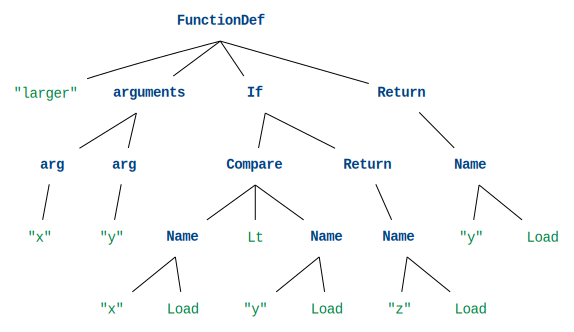

In [61]:
show_ast(ast.parse(inspect.getsource(larger)))

In [62]:
repaired = debug_and_repair(larger,
                                   LARGER_PASSING_TESTCASES +
                                   LARGER_FAILING_TESTCASES,
                                   larger_test, 2)
print_content(repaired, '.py')

/home/milan/Downloads/debuggingbook-notebooks(4)/debuggingbook-notebooks/Repairer_Copy.ipynb:668: UserWarning: Can't parse extract_undefined_variable
  warnings.warn(f"Can't parse {item.__name__}")


Target code to be repaired:
def larger(x, y):
    if x < y:
        return z
    return y

Found conditions ['(x < y)']
Evolving population: iteration   0/5000 fitness = 1.0   

New best code (fitness = 1.0):
def larger(x, y):
    if not x < y:
        return x
    return y


Reduced code (fitness = 1.0):
def larger(x, y):
    if not x < y:
        return x
    return y

It took the MetaRepairer 9.535854816436768 seconds to repair the given code
def larger(x, y):
    if not x < y:
        return x
    return y

Although `simple_debug_and_repair` produced a correct solution for our example, it does not generalize to other functions.  
So your task is to create the `debug_and_repair()` function which can be applied on any faulty function.

Apart from the function `debug_and_repair()`, you may of course implement your own classes. Make sure, however, that you are using these classes within `debug_and_repair()`. Also, keep in mind to tune the _iteration_ parameter of the `Repairer` so that it has sufficient number of generation to evolve. As it may take too much time to find a solution for an ill-programmed repairer (e.g., consider an infinite `while`loop introduced in the fix), we impose a _10-minute timeout_ for each repair.

## Evaluation

Having you implement `debug_and_repair()` allows us to easily test your implementation by calling the function with its respective arguments and testing the correctness of its output. In this section, we will provide you with some test cases as well as the testing framework for this project. This will help you to assess the quality of your work.  

We define functions as well as test-case generators for these functions. The functions given here should be considered as **public tests**. If you pass all public tests, without hard-coding the solutions, you are guaranteed to achieve **10 points**. The secret tests for the remaining 10 must-have-points have similar defects.

### Factorial

The first function we implement is a _factorial_ function. It is supposed to compute the following formula:  
\begin{equation*}
n! = \textit{factorial}(n) = \prod_{k=1}^{n}k, \quad \text{for $k\geq 1$}
\end{equation*}

Here we define three faulty functions `factorial1`, `factorial2`, and `factorial3` that are supposed to compute the factorial.

In [63]:
def factorial1(n):
    res = 1
    for i in range(1, n):
        res *= i
    return res

def fixed_factorial1(n):
    res = 1
    for i in range(1, n):
        res *= i + 1
    return res

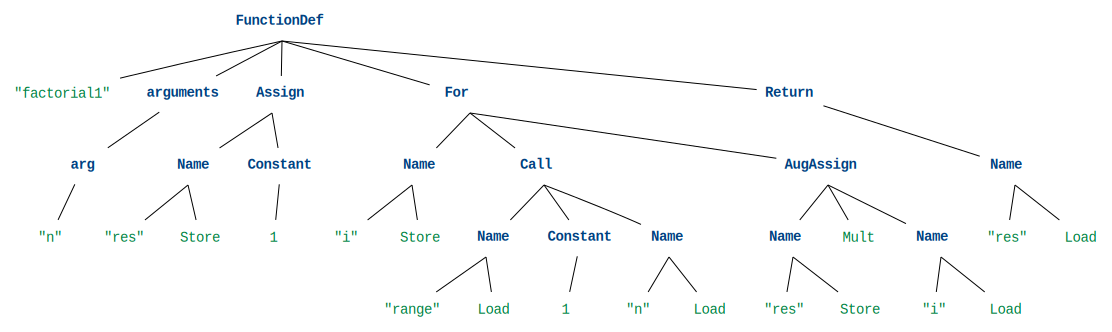

In [64]:
show_ast(ast.parse(inspect.getsource(factorial1)))

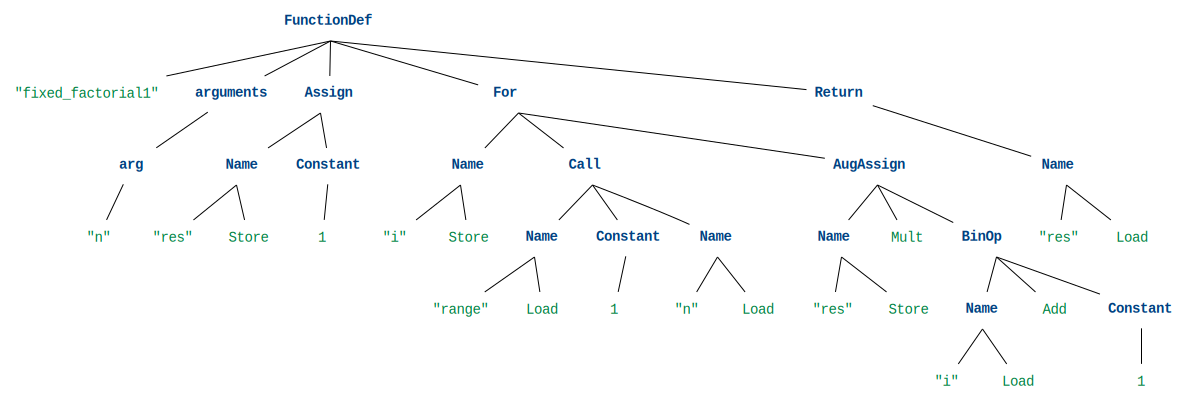

In [65]:
show_ast(ast.parse(inspect.getsource(fixed_factorial1)))

From the first sight, `factorial1` looks to be correctly implemented, still it produces the wrong answer:

In [66]:
factorial1(5)

24

In [67]:
fixed_factorial1(5)

120

while the correct value for 5! is 120.

In [68]:
def factorial_testcase():
    n = random.randrange(100)
    return n

In [69]:
def factorial1_test(n):
    m = factorial1(n)
    assert m == math.factorial(n)

In [70]:
def factorial_passing_testcase():
    while True:
        try:
            n = factorial_testcase()
            _ = factorial1_test(n)
            return (n,)
        except AssertionError:
            pass

In [71]:
def factorial_failing_testcase():
    while True:
        try:
            n = factorial_testcase()
            _ = factorial1_test(n)
        except AssertionError:
            return (n,)

In [72]:
FACTORIAL_PASSING_TESTCASES_1 = [factorial_passing_testcase() for i in range(TESTS)]

In [73]:
FACTORIAL_FAILING_TESTCASES_1 = [factorial_failing_testcase() for i in range(TESTS)]

As we can see, our simple Repairer cannot produce a fix. (Or more precisely, the "fix" it produces is pretty much pointless.)

repaired = debug_and_repair(factorial1,
                            FACTORIAL_PASSING_TESTCASES_1 +
                            FACTORIAL_FAILING_TESTCASES_1,
                            factorial1_test, 2)

The problem is that the current `Repairer` does not provide a suitable mutation to change the right part of the code.

How can we repair this? Consider extending `StatementMutator` operator such that it can mutate various parts of the code, such as ranges, arithmetic operations, variable names etc. (As a reference of how to do that, look at the `ConditionMutator` class.)

The next faulty function is `factorial2()`:

In [74]:
def factorial2(n): 
    i = 1
    for i in range(1, n + 1):
        i *= i
    return i

def fixed_factorial2(n): 
    i = 1
    for x in range(1, n + 1):
        i *= x
    return i

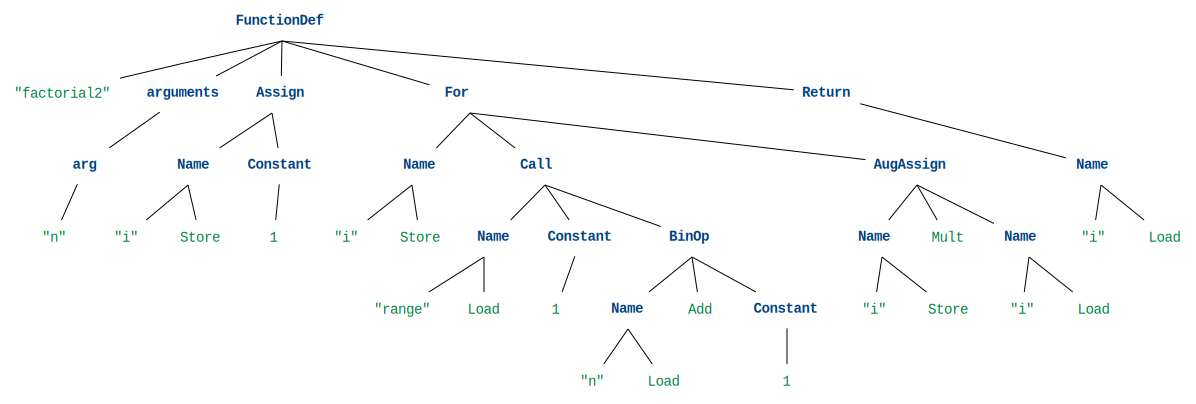

Module(body=[FunctionDef(name='factorial2', args=arguments(posonlyargs=[], args=[arg(arg='n', annotation=None, type_comment=None)], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]), body=[Assign(targets=[Name(id='i', ctx=Store())], value=Constant(value=1, kind=None), type_comment=None), For(target=Name(id='i', ctx=Store()), iter=Call(func=Name(id='range', ctx=Load()), args=[Constant(value=1, kind=None), BinOp(left=Name(id='n', ctx=Load()), op=Add(), right=Constant(value=1, kind=None))], keywords=[]), body=[AugAssign(target=Name(id='i', ctx=Store()), op=Mult(), value=Name(id='i', ctx=Load()))], orelse=[], type_comment=None), Return(value=Name(id='i', ctx=Load()))], decorator_list=[], returns=None, type_comment=None)], type_ignores=[])


In [75]:
show_ast(ast.parse(inspect.getsource(factorial2)))
print(ast.dump(ast.parse(inspect.getsource(factorial2))))

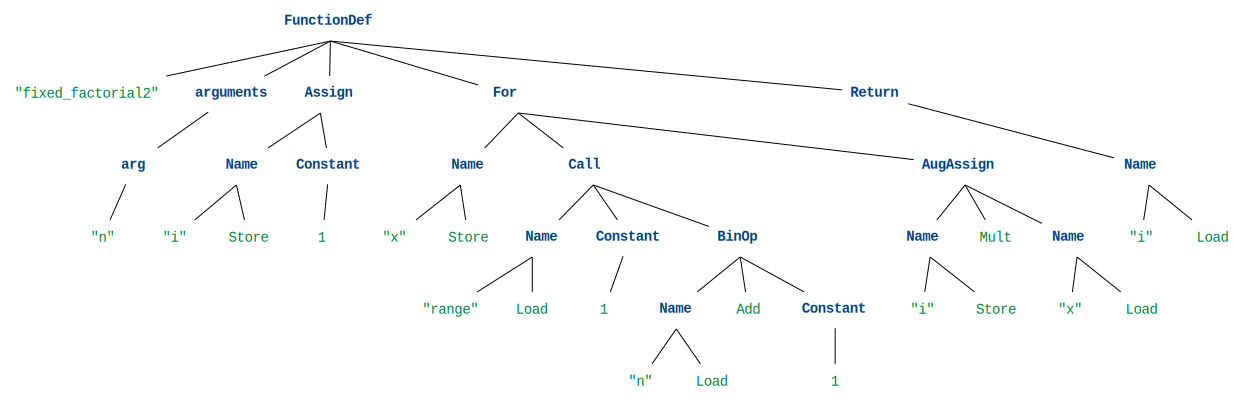

In [76]:
show_ast(ast.parse(inspect.getsource(fixed_factorial2)))

Again, it outputs the incorrect answer:

In [77]:
factorial2(5)

25

In [78]:
def factorial2_test(n):
    m = factorial2(n)
    assert m == math.factorial(n)

In [79]:
def factorial_passing_testcase():
    while True:
        try:
            n = factorial_testcase()
            _ = factorial2_test(n)
            return (n,)
        except AssertionError:
            pass

In [80]:
def factorial_failing_testcase():
    while True:
        try:
            n = factorial_testcase()
            _ = factorial2_test(n)
        except AssertionError:
            return (n,)

In [81]:
FACTORIAL_PASSING_TESTCASES_2 = [factorial_passing_testcase()
                                 for i in range(TESTS)]

In [82]:
FACTORIAL_FAILING_TESTCASES_2 = [factorial_failing_testcase()
                                 for i in range(TESTS)]

repaired2 = debug_and_repair(factorial2,
                            FACTORIAL_PASSING_TESTCASES_2 +
                            FACTORIAL_FAILING_TESTCASES_2,
                            factorial2_test, 2)

The third faulty function is `factorial3()`:

In [83]:
def factorial3(n): 
    res = 1
    for i in range(1, n + 1):
        res += i
    return res

def fixed_factorial3(n): 
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res

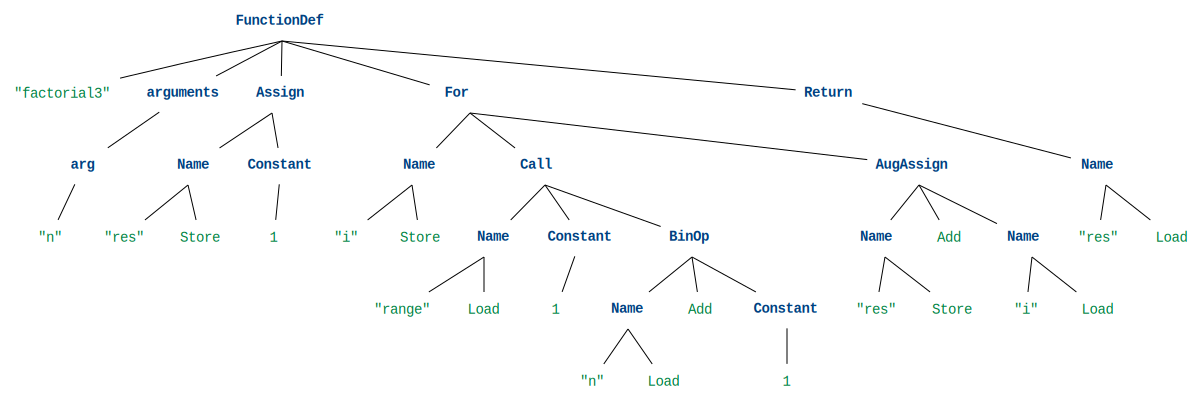

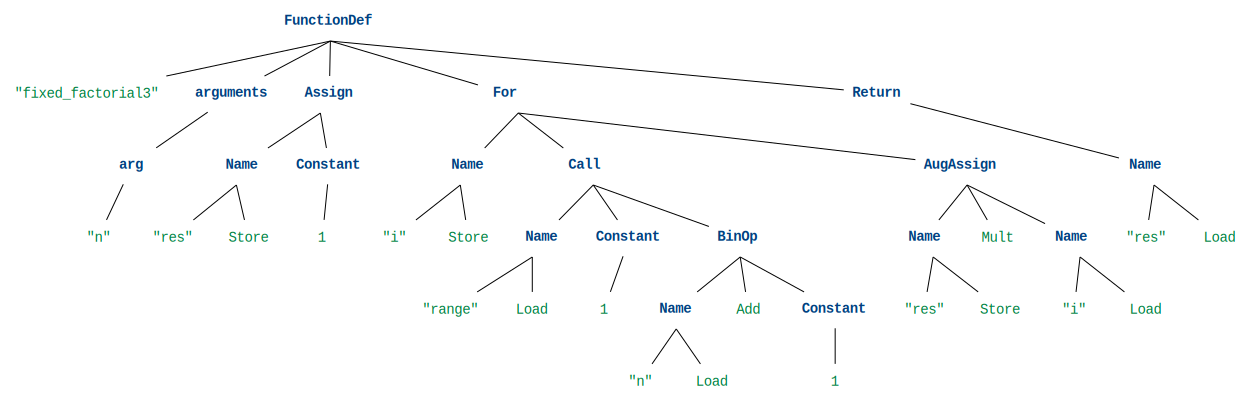

In [84]:
show_ast(ast.parse(inspect.getsource(factorial3)))
show_ast(ast.parse(inspect.getsource(fixed_factorial3)))

In [85]:
factorial3(5)

16

In [86]:
fixed_factorial3(5)

120

In [87]:
def factorial3_test(n):
    m = factorial3(n)
    assert m == math.factorial(n)

In [88]:
def factorial_passing_testcase():
    while True:
        try:
            n = factorial_testcase()
            _ = factorial3_test(n)
            return (n,)
        except AssertionError:
            pass

In [89]:
def factorial_failing_testcase():
    while True:
        try:
            n = factorial_testcase()
            _ = factorial3_test(n)
        except AssertionError:
            return (n,)

In [90]:
FACTORIAL_PASSING_TESTCASES_3 = [factorial_passing_testcase()
                                 for i in range(TESTS)]

In [91]:
FACTORIAL_FAILING_TESTCASES_3 = [factorial_failing_testcase()
                                 for i in range(TESTS)]

repaired3 = debug_and_repair(factorial3,
                            FACTORIAL_PASSING_TESTCASES_3 +
                            FACTORIAL_FAILING_TESTCASES_3,
                            factorial3_test, 2)

### Middle

The following faulty function is the already well known _Middle_ function, though with another defect.

In [92]:
def middle(x, y, z):
    if x < x:
        if y < z:
            return y
        if x < z:
            return z
        return x
    if x < z:
        return x
    if y < z:
        return z
    return y

def middle_fixed(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

It should return the second largest number of the input, but it does not:

In [93]:
middle(2, 3, 1)

3

In [94]:
def middle_testcase():
    x = random.randrange(10)
    y = random.randrange(10)
    z = random.randrange(10)
    return x, y, z

In [95]:
def middle_test(x, y, z):
    m = middle(x, y, z)
    assert m == sorted([x, y, z])[1]

In [96]:
def middle_passing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
            return x, y, z
        except AssertionError:
            pass

In [97]:
def middle_failing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
        except AssertionError:
            return x, y, z

In [98]:
MIDDLE_PASSING_TESTCASES = [middle_passing_testcase()
                            for i in range(TESTS)]

In [99]:
MIDDLE_FAILING_TESTCASES = [middle_failing_testcase()
                            for i in range(TESTS)]

repaired4 = debug_and_repair(middle,
                            MIDDLE_PASSING_TESTCASES +
                            MIDDLE_FAILING_TESTCASES,
                            middle_test, 2)

### Power

The power function should implement the following formular:
\begin{equation*}
\textit{power}(x, n) = x^n, \quad \text{for $x\geq 0$ and $n \geq 0$}
\end{equation*}

In [100]:
def power(x, n):
    res = 1
    for i in range(0, x):
        res *= n
    return res

def fixed_power(x, n):
    res = 1
    for i in range(0, n):
        res *= x
    return res

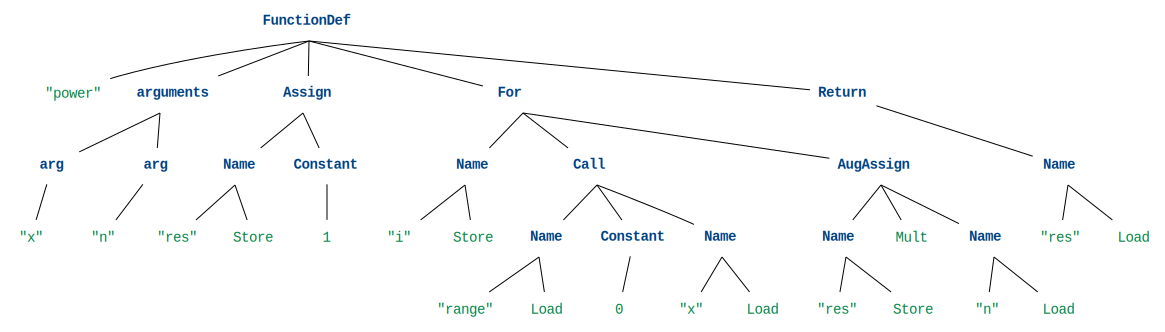

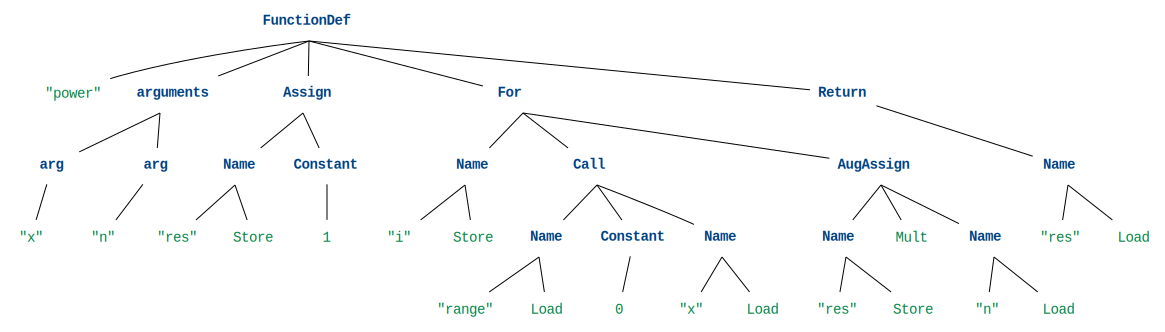

In [101]:
show_ast(ast.parse(inspect.getsource(power)))
show_ast(ast.parse(inspect.getsource(power)))

However, this `power()` function either has an uncommon interpretation of $x^y$ – or it is simply wrong:

In [102]:
power(2, 5)

25

In [103]:
fixed_power(2, 5)

32

We go with the simpler explanation that `power()` is wrong. The correct value, of course, should be $2^5 = 32$.

In [104]:
def power_testcase():
    x = random.randrange(100)
    n = random.randrange(100)
    return x, n

In [105]:
def power_test(x, n):
    m = power(x, n)
    assert m == pow(x, n)

In [106]:
def power_passing_testcase():
    while True:
        try:
            x, n = power_testcase()
            _ = power_test(x, n)
            return x, n
        except AssertionError:
            pass

In [107]:
def power_failing_testcase():
    while True:
        try:
            x, n = power_testcase()
            _ = power_test(x, n)
        except AssertionError:
            return x, n

In [108]:
POWER_PASSING_TESTCASES = [power_passing_testcase()
                           for i in range(TESTS)]

In [109]:
POWER_FAILING_TESTCASES = [power_failing_testcase()
                           for i in range(TESTS)]

repaired5 = debug_and_repair(power,
                            POWER_PASSING_TESTCASES +
                            POWER_FAILING_TESTCASES,
                            power_test, 3)

### Tester Class

To make it convenient to test your solution we provide a testing framework:

In [110]:
import re

In [111]:
class Test:
    def __init__(self, function, testcases, 
                 test_function, assert_function):
        self.function = function
        self.testcases = testcases
        self.test_function = test_function
        self.assert_function = assert_function

    def run(self, repair_function):
        repaired = repair_function(self.function,
                                   self.testcases,
                                   self.test_function)
        repaired = re.sub(self.function.__name__, 'foo', repaired)
        exec(repaired, globals())

        for test in self.testcases:
            res = foo(*test)
            if(int(res) != int(self.assert_function(*test))):
                print(f"Result differs: {res} != {self.assert_function(*test)} on input {test} for function {self.function}, test function {self.test_function}")
            assert int(res) == (self.assert_function(*test))

In [112]:
def middle_assert(x, y, z):
    return sorted([x, y, z])[1]

In [113]:
print(ast.dump(ast.parse('a += a + 1')))

Module(body=[AugAssign(target=Name(id='a', ctx=Store()), op=Add(), value=BinOp(left=Name(id='a', ctx=Load()), op=Add(), right=Constant(value=1, kind=None)))], type_ignores=[])


In [114]:
test0 = Test(factorial1, FACTORIAL_PASSING_TESTCASES_1 + FACTORIAL_FAILING_TESTCASES_1, factorial1_test, math.factorial)
test1 = Test(factorial2, FACTORIAL_PASSING_TESTCASES_2 + FACTORIAL_FAILING_TESTCASES_2, factorial2_test, math.factorial)
test2 = Test(factorial3, FACTORIAL_PASSING_TESTCASES_3 + FACTORIAL_FAILING_TESTCASES_3, factorial3_test, math.factorial)
test3 = Test(middle, MIDDLE_PASSING_TESTCASES + MIDDLE_FAILING_TESTCASES, middle_test, middle_assert)
test4 = Test(power, POWER_PASSING_TESTCASES + POWER_FAILING_TESTCASES, power_test, pow)

In [115]:
tests = [test0, test1, test2, test3, test4]

In [116]:
class Tester:

    def __init__(self, function, tests):
        self.function = function
        self.tests = tests
        random.seed(42)  # We use this seed for our evaluation; don't change it.

    def run_tests(self):
        for test in self.tests:
            try:
                test.run(self.function)
                print(f'Test {test.function.__name__}: OK')
            except AssertionError:
                print(f'Test {test.function.__name__}: Failed')

In [117]:
tester = Tester(debug_and_repair, tests)
tester.run_tests()

Target code to be repaired:
def factorial1(n):
    res = 1
    for i in range(1, n):
        res *= i
    return res

Found conditions []
Evolving population: iteration   0/5000 fitness = 1.0   
Best code (fitness = 1.0):
def factorial1(n):
    res = 1
    for i in range(1, n):
        res *= i + 1
    return res

Reduced code (fitness = 1.0):
def factorial1(n):
    res = 1
    for i in range(1, n):
        res *= i + 1
    return res

It took the MetaRepairer 13.409250974655151 seconds to repair the given code
Test factorial1: OK
Target code to be repaired:
def factorial2(n):
    i = 1
    for i in range(1, n + 1):
        i *= i
    return i

Found conditions []
Evolving population: iteration   0/5000 fitness = 1.0   
Best code (fitness = 1.0):
def factorial2(n):
    i = 1
    for replacement_id0 in range(1, n + 1):
        i *= replacement_id0
    return i

Reduced code (fitness = 1.0):
def factorial2(n):
    i = 1
    for replacement_id0 in range(1, n + 1):
        i *= replacement

## Grading

Your project will be graded by _automated tests_. The tests are executed in the same manner as shown above.
In total there are **20 points** + **10 bonus points** to be awarded for this project. **20 points** for the must-haves, **10 bonus points** for may-haves.

### Must-Haves (20 points)

Must haves include an implementation of the `debug_and_repair` function in a way that it automatically repairs faulty functions given sufficiantly large test suites.
**10 points** are awarded for passing the tests in this notebook. Each passing test being worth two points.
**10 points** are awarded for passing secret tests.

### May-Haves (10 points)

May-haves will also be tested with secret tests, and award **2 points** each. The may-have-features for this project are a more robust implementation, that is able to cope with a wider range of defects:

* Infinite loops
* Infinite recursion (`RecursionError` in Python)
* Type errors (`TypeError` in Python)
* Undefined identifiers (`NameError` in Python)

### General Rules

You need to achieve at least **10 points** to be awarded any points at all.  
Tests must be passed without hard-coding results, otherwise no points are awarded.  
Your code needs to be sufficiently documented in order to achieve points!